femのサロゲートモデル学習用

In [ ]:
import os
import zipfile

# --- Colab/ローカル両対応フラグ ---
USE_COLAB = False  # TrueならColab用、Falseならローカル用

if USE_COLAB:
    # Colab用: パッケージインストール
    !pip install torch numpy pyvista pyvistaqt tqdm vtk pandas

    # Colab用: データダウンロード＆解凍
    import os
    import zipfile
    DATA_URL = "https://github.com/WOCae/R211/raw/main/vtu.zip"
    os.makedirs('vtu', exist_ok=True)
    !wget -O data_files.zip "{DATA_URL}"
    with zipfile.ZipFile('data_files.zip', 'r') as zip_ref:
        zip_ref.extractall('vtu')
    print("Colab: データ解凍完了")
else:
    # ローカル用: パッケージインストール（必要ならコメント解除）
    # !pip install torch numpy pyvista pyvistaqt tqdm vtk pandas

    # ローカル用: データは既に配置済みと仮定（vtuフォルダが存在）
    print("ローカル: vtuフォルダが存在する前提で進みます")

# 共通: vtuファイル一覧取得
import glob
vtu_files = sorted(glob.glob("vtu/**/*.vtu", recursive=True))
print(f"vtuファイル数: {len(vtu_files)}")
if len(vtu_files) > 0:
    print(f"最初のファイル: {vtu_files[0]}")

ローカル: vtuフォルダが存在する前提で進みます
vtuファイル数: 6
最初のファイル: vtu_-\1_-1000.vtu


In [52]:
import torch
# --- 設定の一括管理（メモリ節約モード） ---
class Config:
    # 3Dグリッド解像度
    nx, ny, nz = 24, 24, 24

    # 荷重の正規化係数
    load_norm = 10000.0

    # 物理量のスケール（正規化・復元用）
    scales = {
        'ux': 1e-4, 'uy': 1e-4, 'uz': 1e-4,
        'mises': 1e7,
        'disp': 1e-4,
        'stress': 1e7
    }

    # デバイス設定
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 可視化・復元用の定数
    NORM_DISP = 1e-4
    NORM_STRESS = 1e7
    LOAD_NORM_FACTOR = 10000.0

    # 物理座標の範囲（必要なら追加）
    x_range = (0.0, 10.0)
    y_range = (0.0, 10.0)
    z_range = (0.0, 100.0)


print(f"Using device: {Config.device}")
print(f"Grid size: {Config.nx}x{Config.ny}x{Config.nz}")

Using device: cpu
Grid size: 24x24x24


In [53]:
import pyvista as pv
import numpy as np

def load_case(vtu_path):
    """1つのVTUファイルから節点座標, 変位, ミーゼス応力を読み込む"""
    mesh = pv.read(vtu_path)
    pts = mesh.points.astype(np.float32)
    disp = mesh.point_data["Displacement"].astype(np.float32)
    mises = mesh.point_data["von Mises Stress"].astype(np.float32)
    return pts, disp, mises

In [54]:
import numpy as np
from scipy.interpolate import NearestNDInterpolator

def interpolate_to_grid_3d_optimized(pts, disp, mises):
    points = pts[:, :3]
    gx = np.linspace(Config.x_range[0], Config.x_range[1], Config.nx, dtype=np.float32)
    gy = np.linspace(Config.y_range[0], Config.y_range[1], Config.ny, dtype=np.float32)
    gz = np.linspace(Config.z_range[0], Config.z_range[1], Config.nz, dtype=np.float32)
    grid_x, grid_y, grid_z = np.meshgrid(gx, gy, gz, indexing='ij')
    target_points = np.stack([grid_x.ravel(), grid_y.ravel(), grid_z.ravel()], axis=-1)
    values = np.column_stack([disp[:,0], disp[:,1], disp[:,2], mises])
    interp = NearestNDInterpolator(points, values)
    interpolated = interp(target_points)
    result_grid = interpolated.reshape(Config.nx, Config.ny, Config.nz, 4)
    ux = result_grid[..., 0]
    uy = result_grid[..., 1]
    uz = result_grid[..., 2]
    ms = result_grid[..., 3]
    return ux, uy, uz, ms

def make_inp_out(pts, disp, mises, load_value):
    ux, uy, uz, ms = interpolate_to_grid_3d_optimized(pts, disp, mises)
    geo_mask = np.ones((Config.nx, Config.ny, Config.nz), dtype=np.float32)
    fix_mask = np.zeros_like(geo_mask)
    fix_mask[:, :, 0] = 1.0
    load_mask = np.zeros_like(geo_mask)
    load_mask[:, :, -1] = 1.0
    val_channel = np.full_like(geo_mask, load_value, dtype=np.float32)
    inp = np.stack([geo_mask, fix_mask, load_mask, val_channel], axis=0)
    ux_n = ux / Config.scales['disp']
    uy_n = uy / Config.scales['disp']
    uz_n = uz / Config.scales['disp']
    ms_n = ms / Config.scales['stress']
    out = np.stack([ux_n, uy_n, uz_n, ms_n], axis=0)
    return inp, out

In [ ]:
import glob
import os
from tqdm import tqdm

from torch.utils.data import TensorDataset, DataLoader

vtu_files = sorted(glob.glob("vtu/**/*.vtu", recursive=True))
inputs = []
outputs = []

print("Processing VTU -> 3D grids...")
for vtu_path in tqdm(vtu_files, total=len(vtu_files)):
    stem = os.path.splitext(os.path.basename(vtu_path))[0]
    try:
        _, load_str = stem.split("_", 1)
        load_val = float(load_str)
    except Exception:
        raise ValueError(f"Could not parse load from file name: {stem}")
    pts, disp, mises = load_case(vtu_path)
    load_norm = load_val / Config.load_norm
    inp, out = make_inp_out(pts, disp, mises, load_norm)
    inp = np.moveaxis(inp, 0, -1).astype(np.float32)
    out = np.moveaxis(out, 0, -1).astype(np.float32)
    inputs.append(inp)
    outputs.append(out)

X_all = np.stack(inputs, axis=0)
Y_all = np.stack(outputs, axis=0)
X_torch = torch.from_numpy(X_all).float()
Y_torch = torch.from_numpy(Y_all).float()
print(f"Input shape:  {X_torch.shape}")
print(f"Output shape: {Y_torch.shape}")
dataset = TensorDataset(X_torch, Y_torch)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

Processing VTU -> 3D grids...


100%|██████████| 6/6 [00:00<00:00, 105.44it/s]

Input shape:  torch.Size([6, 24, 24, 24, 4])
Output shape: torch.Size([6, 24, 24, 24, 4])


In [56]:
import pandas as pd

data_summary = []

for vtu_path in vtu_files:
    stem = os.path.splitext(os.path.basename(vtu_path))[0]
    _, load_str = stem.split("_", 1)
    load_val = float(load_str)
    pts, disp, mises = load_case(vtu_path)
    summary = {
        "File Name": stem,
        "Load [N]": load_val,
        "Uz_Min [m]": np.min(disp[:, 2]),
        "Uz_Max [m]": np.max(disp[:, 2]),
        "Max Mises [Pa]": np.max(mises)
    }
    data_summary.append(summary)

df_train = pd.DataFrame(data_summary)
display(df_train)

,File Name,Load [N],Uz_Min [m],Uz_Max [m],Max Mises [Pa]
0,1_-1000,-1000.0,-0.000005,0.0,9999610.0
1,2_-2000,-2000.0,-0.000010,0.0,19998700.0
2,3_-3000,-3000.0,-0.000014,0.0,29997100.0
3,4_-4000,-4000.0,-0.000019,0.0,39995000.0
4,5_-5000,-5000.0,-0.000024,0.0,49992400.0
5,6_-6000,-6000.0,-0.000029,0.0,59989100.0


In [57]:
import torch.nn as nn
import torch.fft as fft

class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes_x, modes_y, modes_z):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes_x = modes_x
        self.modes_y = modes_y
        self.modes_z = modes_z
        self.weight_real = nn.Parameter(
            torch.randn(in_channels, out_channels, modes_x, modes_y, modes_z) * 0.1
        )
        self.weight_imag = nn.Parameter(
            torch.randn(in_channels, out_channels, modes_x, modes_y, modes_z) * 0.1
        )

    def compl_mul3d(self, input, weight_real, weight_imag):
        real = torch.einsum("bixyz,ioxyz->boxyz", input.real, weight_real) - \
               torch.einsum("bixyz,ioxyz->boxyz", input.imag, weight_imag)
        imag = torch.einsum("bixyz,ioxyz->boxyz", input.real, weight_imag) + \
               torch.einsum("bixyz,ioxyz->boxyz", input.imag, weight_real)
        return torch.complex(real, imag)

    def forward(self, x):
        batchsize, channels, nx, ny, nz = x.shape
        x_ft = fft.rfftn(x, dim=[-3, -2, -1], norm="ortho")
        out_ft = torch.zeros(
            batchsize, self.out_channels, x_ft.size(-3), x_ft.size(-2), x_ft.size(-1),
            dtype=torch.cfloat, device=x.device
        )
        kx, ky, kz = self.modes_x, self.modes_y, self.modes_z
        out_ft[:, :, :kx, :ky, :kz] = self.compl_mul3d(
            x_ft[:, :, :kx, :ky, :kz],
            self.weight_real, self.weight_imag
        )
        return fft.irfftn(out_ft, s=(nx, ny, nz), dim=[-3, -2, -1], norm="ortho")

class FNO3d(nn.Module):
    def __init__(self, in_channels=4, out_channels=4, width=32, modes=8):
        super().__init__()
        self.width = width
        self.fc_in = nn.Linear(in_channels, width)
        self.convs = nn.ModuleList([SpectralConv3d(width, width, modes, modes, modes) for _ in range(4)])
        self.ws = nn.ModuleList([nn.Conv3d(width, width, 1) for _ in range(4)])
        self.fc_out1 = nn.Linear(width, 128)
        self.fc_out2 = nn.Linear(128, out_channels)
        self.act = nn.GELU()

    def forward(self, x):
        x = self.fc_in(x)
        x = x.permute(0, 4, 1, 2, 3)
        for conv, w in zip(self.convs, self.ws):
            x1 = conv(x)
            x2 = w(x)
            x = self.act(x1 + x2)
        x = x.permute(0, 2, 3, 4, 1)
        x = self.act(self.fc_out1(x))
        x = self.fc_out2(x)
        return x

In [58]:
model = FNO3d(
    in_channels=4,
    out_channels=4,
    width=32,
    modes=8,
).to(Config.device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

print("Start 3D FNO training...")
for epoch in range(50):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb = xb.to(Config.device)
        yb = yb.to(Config.device)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(loader)
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1:3d} / 50, Loss = {avg_loss:.6e}")
print("Training Finished (3D FNO).")

Start 3D FNO training...
Epoch   5 / 50, Loss = 1.793689e+00
Epoch  10 / 50, Loss = 7.197543e-01
Epoch  15 / 50, Loss = 6.013862e-01
Epoch  20 / 50, Loss = 4.526658e-01
Epoch  25 / 50, Loss = 1.027597e-01
Epoch  30 / 50, Loss = 1.594190e-02
Epoch  35 / 50, Loss = 7.958297e-03
Epoch  40 / 50, Loss = 5.811608e-03
Epoch  45 / 50, Loss = 2.091534e-03
Epoch  50 / 50, Loss = 2.436454e-03
Training Finished (3D FNO).


★ 予測結果サマリー（荷重: -2000.0 N）
荷重点インデックス: (ix, iy, iz) = (12, 12, 23)
荷重点物理座標: (x, y, z) = (5.22, 5.22, 100.00)
----------------------------------------
Ux (荷重点) : -1.911e-06 [m]
Uy (荷重点) : 2.209e-06 [m]
Uz (荷重点) : -8.340e-06 [m]
von Mises応力 (荷重点) : 19.544 [MPa]


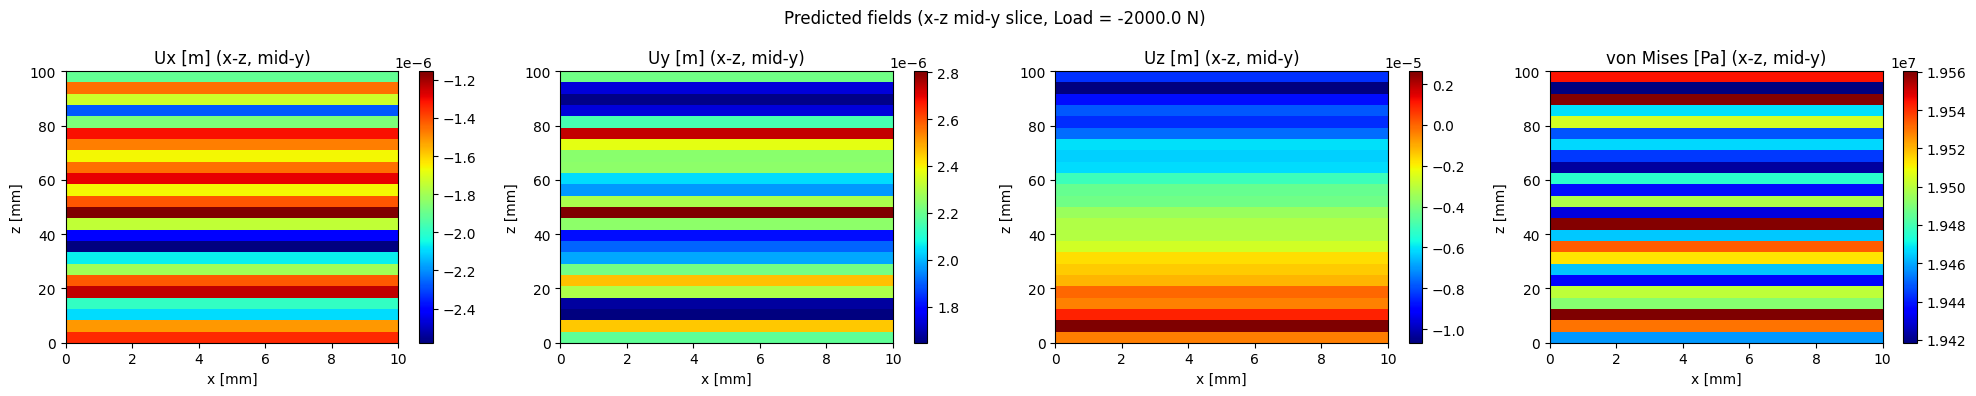

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# import torch

# --- 任意荷重ケースでの3D推論 ---

# 1. 入力と同じ形のマスクを作るために、どれか1つ既存ケースのVTUを基準にする
base_vtu = vtu_files[0]  # 形状は全ケース共通想定
pts_base, disp_base, mises_base = load_case(base_vtu)

# 2. 3Dグリッド座標は学習時と同じ Config の範囲を使用
nx, ny, nz = Config.nx, Config.ny, Config.nz

# Geometry / BC / Load のマスク生成
geo_mask  = np.ones((nx, ny, nz), dtype=np.float32)
fix_mask  = np.zeros_like(geo_mask, dtype=np.float32); fix_mask[:, :, 0]  = 1.0
load_mask = np.zeros_like(geo_mask, dtype=np.float32); load_mask[:, :, -1] = 1.0

# 3. 任意荷重値（N）を指定
any_load_N = -2000.0
load_value_norm = any_load_N / Config.load_norm
val_channel = np.full_like(geo_mask, load_value_norm, dtype=np.float32)

# 4. 入力テンソルを作成
inp_np = np.stack([geo_mask, fix_mask, load_mask, val_channel], axis=-1)
inp_torch = torch.from_numpy(inp_np).unsqueeze(0).to(Config.device)

# 5. 推論
model.eval()
with torch.no_grad():
    pred = model(inp_torch)

pred_np = pred.squeeze(0).cpu().numpy()

# 6. 物理量に復元
ux_pred = pred_np[..., 0] * Config.scales['disp']
uy_pred = pred_np[..., 1] * Config.scales['disp']
uz_pred = pred_np[..., 2] * Config.scales['disp']
mises_pred = pred_np[..., 3] * Config.scales['stress']

# 荷重点（x, y 中央, z=最大）のインデックス
ix = ux_pred.shape[0] // 2
iy = ux_pred.shape[1] // 2
iz = ux_pred.shape[2] - 1

# 物理座標
x_phys = np.linspace(Config.x_range[0], Config.x_range[1], ux_pred.shape[0])[ix]
y_phys = np.linspace(Config.y_range[0], Config.y_range[1], ux_pred.shape[1])[iy]
z_phys = np.linspace(Config.z_range[0], Config.z_range[1], ux_pred.shape[2])[iz]

print("="*40)
print(f"★ 予測結果サマリー（荷重: {any_load_N:.1f} N）")
print(f"荷重点インデックス: (ix, iy, iz) = ({ix}, {iy}, {iz})")
print(f"荷重点物理座標: (x, y, z) = ({x_phys:.2f}, {y_phys:.2f}, {z_phys:.2f})")
print("-" * 40)
print(f"Ux (荷重点) : {ux_pred[ix, iy, iz]:.3e} [m]")
print(f"Uy (荷重点) : {uy_pred[ix, iy, iz]:.3e} [m]")
print(f"Uz (荷重点) : {uz_pred[ix, iy, iz]:.3e} [m]")
print(f"von Mises応力 (荷重点) : {mises_pred[ix, iy, iz]/1e6:.3f} [MPa]")
print("="*40)

# 7. 代表スライスの簡易可視化
y_mid = ny // 2
x_min, x_max = Config.x_range
z_min, z_max = Config.z_range

ux_xz = ux_pred[:, y_mid, :]
uy_xz = uy_pred[:, y_mid, :]
uz_xz = uz_pred[:, y_mid, :]
mises_xz = mises_pred[:, y_mid, :]

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
fig.suptitle(f"Predicted fields (x-z mid-y slice, Load = {any_load_N} N)")

im0 = axes[0].imshow(ux_xz.T, origin='lower', cmap='jet', extent=[x_min, x_max, z_min, z_max], aspect='auto')
axes[0].set_title('Ux [m] (x-z, mid-y)')
axes[0].set_xlabel('x [mm]')
axes[0].set_ylabel('z [mm]')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(uy_xz.T, origin='lower', cmap='jet', extent=[x_min, x_max, z_min, z_max], aspect='auto')
axes[1].set_title('Uy [m] (x-z, mid-y)')
axes[1].set_xlabel('x [mm]')
axes[1].set_ylabel('z [mm]')
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(uz_xz.T, origin='lower', cmap='jet', extent=[x_min, x_max, z_min, z_max], aspect='auto')
axes[2].set_title('Uz [m] (x-z, mid-y)')
axes[2].set_xlabel('x [mm]')
axes[2].set_ylabel('z [mm]')
plt.colorbar(im2, ax=axes[2])

im3 = axes[3].imshow(mises_xz.T, origin='lower', cmap='jet', extent=[x_min, x_max, z_min, z_max], aspect='auto')
axes[3].set_title('von Mises [Pa] (x-z, mid-y)')
axes[3].set_xlabel('x [mm]')
axes[3].set_ylabel('z [mm]')
plt.colorbar(im3, ax=axes[3])

plt.tight_layout()
plt.show()